# Vector overlay operations

Map overlay is probably the oldest analysis technique in GIS to understand relations between layers of geographic information. Already in the mid 19th century, John Snow famously identified the source of cholera outbreak in London to a specific public water pump by overlaying two point maps on top of each other ({cite}`unwin_1996`). Map overlay has been an important analytical tool for very long time, as being able to combine and analyse multiple layers of spatial data together is crucial for various spatial planning processes, including e.g. suitability analyses, environment impact assessment, or when doing zoning and landuse plans (e.g. {cite}`keeble_1952`; {cite}`masser_1999`; {cite}`steinitz_1976`). 

Overlay operations can be done both with vector and raster data. Vector overlay operations are commonly used technique to produce new geometries and associated attribute data based on two or more vector layers. When working with multiple spatial datasets (especially polygon or line layers), you might need to create new shapes based on places where the layers overlap (or do not overlap) with each other. Typical overlay operations include union, intersection, and difference (Figure 6.52). These are named after the result of the combination of two or more input layers which produce at least one (or more) output layer. Being able to combine spatial data layers like this is an important feature in most GIS tools. These manipulations are also often called as set operations.

The basic idea of vector overlay operations is demonstrated in Figure 6.53 where the green areas represent the areas which constitute the result after the overlay operation. It is good to keep in mind that overlays operate at the `GeoDataFrame` level, not on individual geometries, and the properties from both are retained (often, not always). In effect, for every shape in the left `GeoDataFrame`, this operation is executed against every other shape in the right `GeoDataFrame`

![_**Figure 6.53**. Typical vector overlay operations between two geographic layers (circle and rectangles). _](../img/vector_overlay_processes.png)

_**Figure 6.53**. Typical vector overlay operations between two geographic layers (circle and rectangles)._


To demonstrate how these overlay operations work in practice, we will carry out vector overlay operations between two Polygon datasets that represent i) the postal code areas in the Helsinki city center and ii) a 3000 meter buffer around the Helsinki railway center. Let's start by reading the datasets and prepare them for analysis:

In [1]:
import geopandas as gpd

postal_areas = gpd.read_file("data/Helsinki/Helsinki_centre_postal_areas.gpkg")
railway_station = gpd.read_file("data/Helsinki/Helsinki_railway_station.gpkg")

# Check the data
postal_areas.head()

,posti_alue,he_vakiy,index_right,density,geometry
0,00100,18284.0,0,7769.586237,"MULTIPOLYGON (((385653.893 6671591.048, 385573..."
1,00120,7108.0,0,17168.685515,"MULTIPOLYGON (((385316.092 6671076.984, 385279..."
2,00130,1508.0,0,3515.476578,"MULTIPOLYGON (((386212.111 6671061.262, 386176..."
3,00140,7865.0,0,8440.281536,"MULTIPOLYGON (((386577.05 6670280.544, 386552...."
4,00150,9496.0,0,6944.933965,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."


In [2]:
postal_areas.shape

(30, 5)

In [3]:
railway_station.head()

,name,id,geometry
0,Helsinki Railway station,0,POINT (385738.777 6672297.759)


From here we can see that the `postal_areas` include MultiPolygon geometries representing altogether thirty postal code areas, whereas the `railway_station` represents a single `Point` for the Helsinki Railway station. As vector overlay operation happens between two geographic datasets, it is necessary to ensure that they both share the same Coordinate Reference System. Hence, let's first check that the `.crs` are matching using the Python's `assert` statement that tests whether the condition is `True`. If the test fails, the `assert` will throw an `AssertionError` with the message that we provide as text like in the following:

In [4]:
assert postal_areas.crs == railway_station.crs, "The CRS does not match!"

Great, the CRS matches between the layers. Hence, let's continue and create a 3 kilometer buffer around the Helsinki railway station which we will use in our vector overlay operations:

In [5]:
station_buffer = railway_station.copy()
station_buffer["geometry"] = station_buffer.buffer(3000)

Here, we first created a copy of the original `GeoDataFrame` and then used the `.buffer()` method to create a Polygon circle with 3000 meter radius. Let's visualize the data on a map so that we can get a better understanding of the two layers and how they overlap with each other:

In [26]:
m = postal_areas.explore(tiles="CartoDB Positron")
m = station_buffer.explore(m=m, color="red")
m

_**Figure 6.54**. A sample of postal code areas in the Helsinki city centre and a 3km buffer around Helsinki railway station._

## Intersection

We are now ready to conduct an overlay analysis between these layers. We will create a new layer based postal code polygons that `intersect` with our Helsinki layer. We can use a method called `.overlay()` to conduct the overlay analysis between the given `GeoDataFrame` (`postal_areas`) and a second `GeoDataFrame` (`station_buffer`). With parameter `how` we can control how the overlay analysis is conducted. Possible values are `'intersection'`, `'union'`, `'symmetric_difference'`, `'difference'`, and `'identity'`. Let's start by doing an overlay using `"intersection"` as the overlay operation:

In [7]:
# Intersection
intersection = postal_areas.overlay(station_buffer, how="intersection")
intersection.head()

,posti_alue,he_vakiy,index_right,density,name,id,geometry
0,00100,18284.0,0,7769.586237,Helsinki Railway station,0,"POLYGON ((385573.62 6671699.801, 385612.659 66..."
1,00120,7108.0,0,17168.685515,Helsinki Railway station,0,"POLYGON ((385279.612 6671123.567, 385255.478 6..."
2,00130,1508.0,0,3515.476578,Helsinki Railway station,0,"POLYGON ((386176.826 6671111.888, 386039.154 6..."
3,00140,7865.0,0,8440.281536,Helsinki Railway station,0,"MULTIPOLYGON (((386552.849 6670283.51, 386528...."
4,00150,9496.0,0,6944.933965,Helsinki Railway station,0,"MULTIPOLYGON (((384823.503 6669566.95, 384799...."


In [8]:
intersection.shape

(23, 7)

As a result we got a new `GeoDataFrame` that includes 23 postal code areas that intersected with the `station_buffer`. As we can see, due to the overlay operation, the dataset contains the attributes from both input layers, i.e. it works in a bit similar manner as `sjoin()` demonstrated in Chapter 6.7. To make it easier to understand how different vector overlay operations work, let's create an easy helper function called `plot_vector_overlay()` that creates a comparison map based on the results before and after the overlay operation. To do this, we use `matplotlib` library and create a subplot with 2 separate plots:

In [9]:
import matplotlib.pyplot as plt


def plot_vector_overlay(gdf1, gdf2, result, title):
    """
    Creates two maps next to each other based on `gdf1`, `gdf2` and the
    `result` GeoDataFrames.
    """

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

    ax1 = gdf1.plot(ax=ax1)
    ax1 = gdf2.plot(ax=ax1, color="red", alpha=0.3)

    result.plot(ax=ax2)

    # Fetch bounds and apply to axis 2
    xmin, ymin, xmax, ymax = gdf1.total_bounds

    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)

    fig.suptitle(title, fontsize=16)
    # Add an arrow between the plots
    fig.text(0.49, 0.5, "⇨", fontsize=30, color="red")
    ax1.axis("off")
    ax2.axis("off")
    plt.tight_layout()
    return fig, ax1, ax2

Now we can call this function to create a visualizaton that demonstrates how the intersection overlay operations behaves:

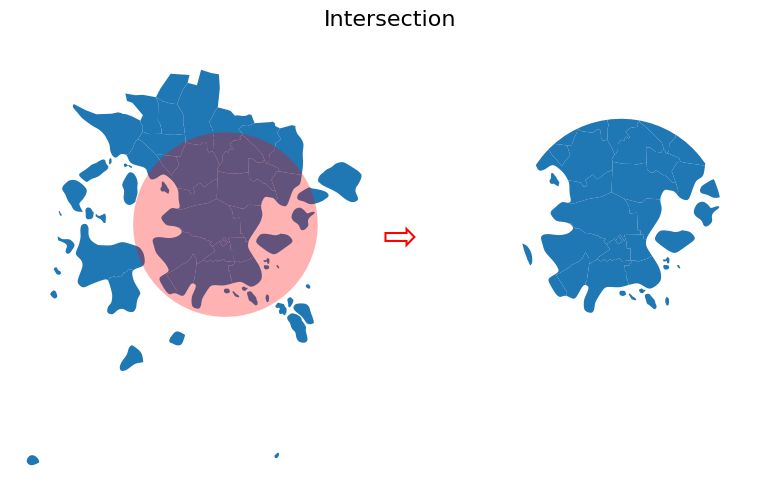

In [10]:
fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas, gdf2=station_buffer, result=intersection, title="Intersection"
)

_**Figure 6.55**. Result after conducting vector overlay operation by intersecting the two layers._

As we can see, the `"intersection"` overlay operation keeps the postal code areas that intersect with the circle and keeps all those geometries in the result. Important thing to notice is that with `overlay()` the intersecting `GeoDataFrame` (`station_buffer`) will also modify the input geometries by cutting them in the border areas where they cross. This is one of the key differences between `.overlay()` and `sjoin()` methods as `sjoin()` will not modify the input geometries. As mentioned earlier, attribute data from both `GeoDataFrames` are kept from the features that are part of the result.  In the following, we will show one-by-one, how different overlay operations (i.e. union, difference, symmetric difference, identity) influence the results.

## Union

In a similar manner as with intersection, we can conduct overlay operation using `"union"` as below:

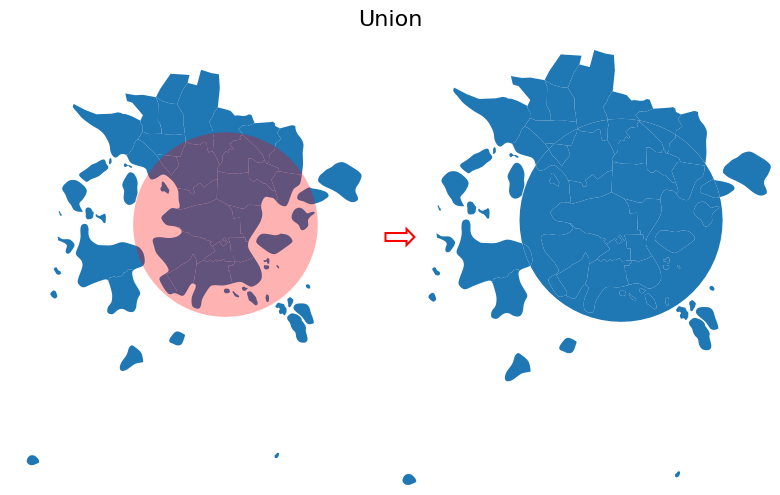

In [11]:
# Union
union = postal_areas.overlay(station_buffer, how="union")

fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas, gdf2=station_buffer, result=union, title="Union"
)

_**Figure 6.56**. Result after conducting vector overlay operation based on union._

In [12]:
union.shape

(42, 7)

When using `"union"` overlay operation, the geometries from both `GeoDataFrames` are kept in the result. As you can see, the number of rows has increased quite significantly from 30 to 42 rows. This happens because the postal code geometries are again modified by the `station_buffer` in the areas where the geometries cross each other: the postal code geometry is splitted in two in areas where the buffer geometry crosses the postal code geometry. Hence, this will increase the number of rows in the final output. 

#### Question 6.13

Did you fully understand why the number of rows increase after doing the union overlay? If not, use the `.explore()` and investigate the geometries in areas where the postal code areas and the ring (border) of the buffer geometry cross each other. When you hover over the border, what happens with the attribute values?

In [13]:
# Use this cell to enter your solution.

In [27]:
# Answer
print(
    """
When hovering over the buffer geometry border, the attribute values in the table change. 
Inside the ring, the attributes of the Helsinki railway station are kept in the results, whereas outside of the ring 
the table does not include any data for the columns associated with the railway station.
"""
)

# Solution
union.explore()


When hovering over the buffer geometry border, the attribute values in the table change. 
Inside the ring, the attributes of the Helsinki railway station are kept in the results, whereas outside of the ring 
the table does not include any data for the columns associated with the railway station.



## Difference and symmetric difference

Sometimes it might be useful to focus extract geometries that area *outside* a given layer. This can be achieved by using the `.overlay()` with `"difference"` operator:

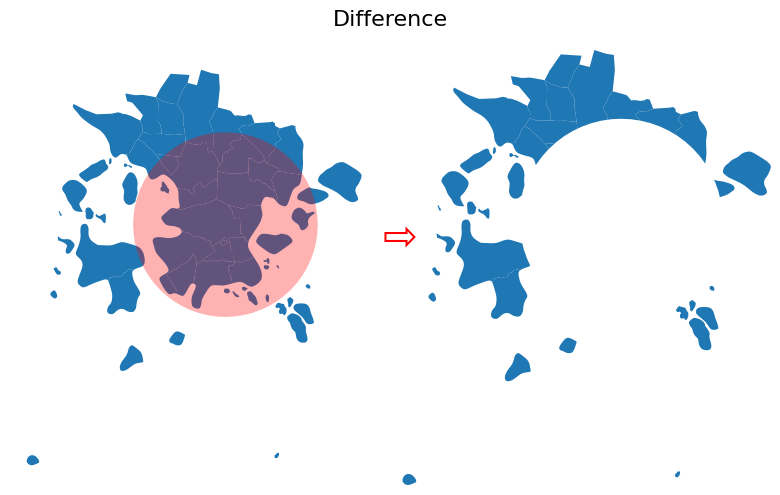

In [15]:
# Difference
difference = postal_areas.overlay(station_buffer, how="difference")

fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas, gdf2=station_buffer, result=difference, title="Difference"
)

_**Figure 6.57**. Result after conducting vector overlay operation based on difference._

In [16]:
difference.columns.values

array(['posti_alue', 'he_vakiy', 'index_right', 'density', 'geometry'],
      dtype=object)

In [17]:
difference.shape

(18, 5)

As can be seen from the results above, the `"difference"` will keep the postal code geometries that are outside of the buffer geometry (note we output `difference.columns.values` here to output only the column names). In terms of attributes, only the columns that are present in the source `GeoDataFrame` (i.e. `postal_areas`) are kept. 

The symmetric difference overlay operation is an interesting one. It will keep the geometries and attributes outside of the `station_buffer` layer, as well as create a geometry within the `station_buffer` that includes areas that are within the `station_buffer` ring but outside the `postal_areas` `GeoDataFrame`. I.e. in our case, it mostly contains water areas that surround the Helsinki city centre as shown below:

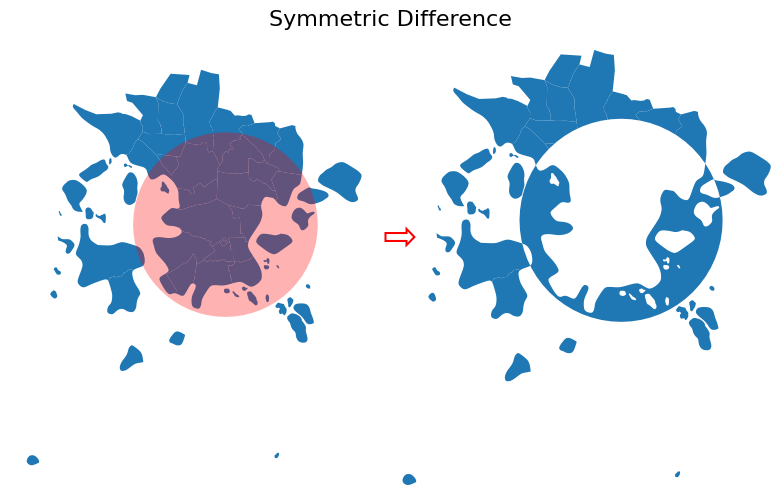

In [18]:
# Symmetric Difference
symmetric_difference = postal_areas.overlay(station_buffer, how="symmetric_difference")

fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas,
    gdf2=station_buffer,
    result=symmetric_difference,
    title="Symmetric Difference",
)

_**Figure 6.58**. Result after conducting vector overlay operation based on symmetric difference._

In [19]:
symmetric_difference.columns

Index(['posti_alue', 'he_vakiy', 'index_right', 'density', 'name', 'id',
       'geometry'],
      dtype='object')

In [20]:
symmetric_difference.shape

(19, 7)

In [21]:
symmetric_difference.tail()

,posti_alue,he_vakiy,index_right,density,name,id,geometry
14,00520,7306.0,0.0,5609.742526,NaN,NaN,"POLYGON ((385333.465 6675315.885, 385335.052 6..."
15,00550,9464.0,0.0,9829.492877,NaN,NaN,"POLYGON ((386285.241 6675258.417, 386164.283 6..."
16,00570,3962.0,0.0,2205.349757,NaN,NaN,"MULTIPOLYGON (((389839.918 6673030.501, 389808..."
17,00580,2727.0,0.0,2109.697366,NaN,NaN,"POLYGON ((387366.285 6674940.194, 387550.714 6..."
18,NaN,NaN,NaN,NaN,Helsinki Railway station,0.0,"MULTIPOLYGON (((383835.597 6669978.727, 383617..."


As can be seen from above, the table includes now the attributes from the `postal_areas` `GeoDataFrame` as well as the attributes from `station_buffer` in the last row of the resulting `GeoDataFrame`. 

## Identity

As a last overlay operation, we have the `"identity"` which computes a geometric intersection of the input features and identity features. The input features or portions thereof that overlap identity features will get the attributes of those identity features. The basic idea is very similar to `"union"` but in this case, the areas outside of `postal_areas` `GeoDataFrame` will not be filled with the `station_buffer` geometry as demonstrated below:

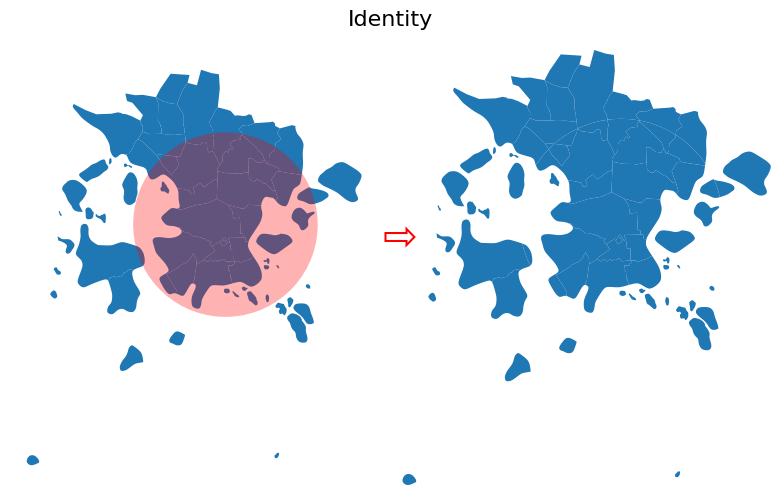

In [22]:
# Identity
identity = postal_areas.overlay(station_buffer, how="identity")

fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas, gdf2=station_buffer, result=identity, title="Identity"
)

_**Figure 6.59**. Result after conducting vector overlay operation based on identity._

In [23]:
identity.columns

Index(['posti_alue', 'he_vakiy', 'index_right', 'density', 'name', 'id',
       'geometry'],
      dtype='object')

In [24]:
identity.shape

(41, 7)

In [25]:
identity.loc[20:25]

,posti_alue,he_vakiy,index_right,density,name,id,geometry
20,00550,9464.0,0.0,9829.492877,Helsinki Railway station,0.0,"POLYGON ((387057.865 6674284.968, 387045.245 6..."
21,00570,3962.0,0.0,2205.349757,Helsinki Railway station,0.0,"MULTIPOLYGON (((388536.474 6672959.818, 388512..."
22,00580,2727.0,0.0,2109.697366,Helsinki Railway station,0.0,"POLYGON ((387749.472 6673979.696, 387491.215 6..."
23,00140,7865.0,0.0,8440.281536,NaN,NaN,"POLYGON ((387352.067 6664714.928, 387339.366 6..."
24,00150,9496.0,0.0,6944.933965,NaN,NaN,"POLYGON ((384180.692 6668373.742, 384154.302 6..."
25,00190,743.0,0.0,971.226183,NaN,NaN,"MULTIPOLYGON (((388259.682 6668460.022, 388233..."


As can be seen from the results above, the output now includes attribute information from both `GeoDataFrames` and the geometries in the `postal_areas` are split into multiple parts in places where the `station_buffer` cuts them. However, the geometry of the `station_buffer` itself is not included at all in the results. 